# Try doing everything for Kepler-444

In [1]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

%config InlineBackend.figure_format = "retina"

# Get the data

Get all Kepler data on Kepler-444 using Lightkurve. To start I get the target pixel files, then convert them to lightcurves using PLD.

In [3]:
search_results = lk.search_targetpixelfile("Kepler-444", mission="Kepler", exptime=1800)
search_results

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006278762,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006278762,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006278762,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006278762,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006278762,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006278762,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr006278762,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr006278762,0.0
8,Kepler Quarter 08,2011,Kepler,1800,kplr006278762,0.0


In [4]:
tpfs = lk.search_targetpixelfile("Kepler-444", mission="Kepler", exptime=1800).download_all()

In [5]:
lcs = [tpf.to_lightcurve(method="pld") for tpf in tpfs]
lcc = lk.LightCurveCollection(lightcurves=lcs)

Now let's look at the separate light curves, coloured by quarter

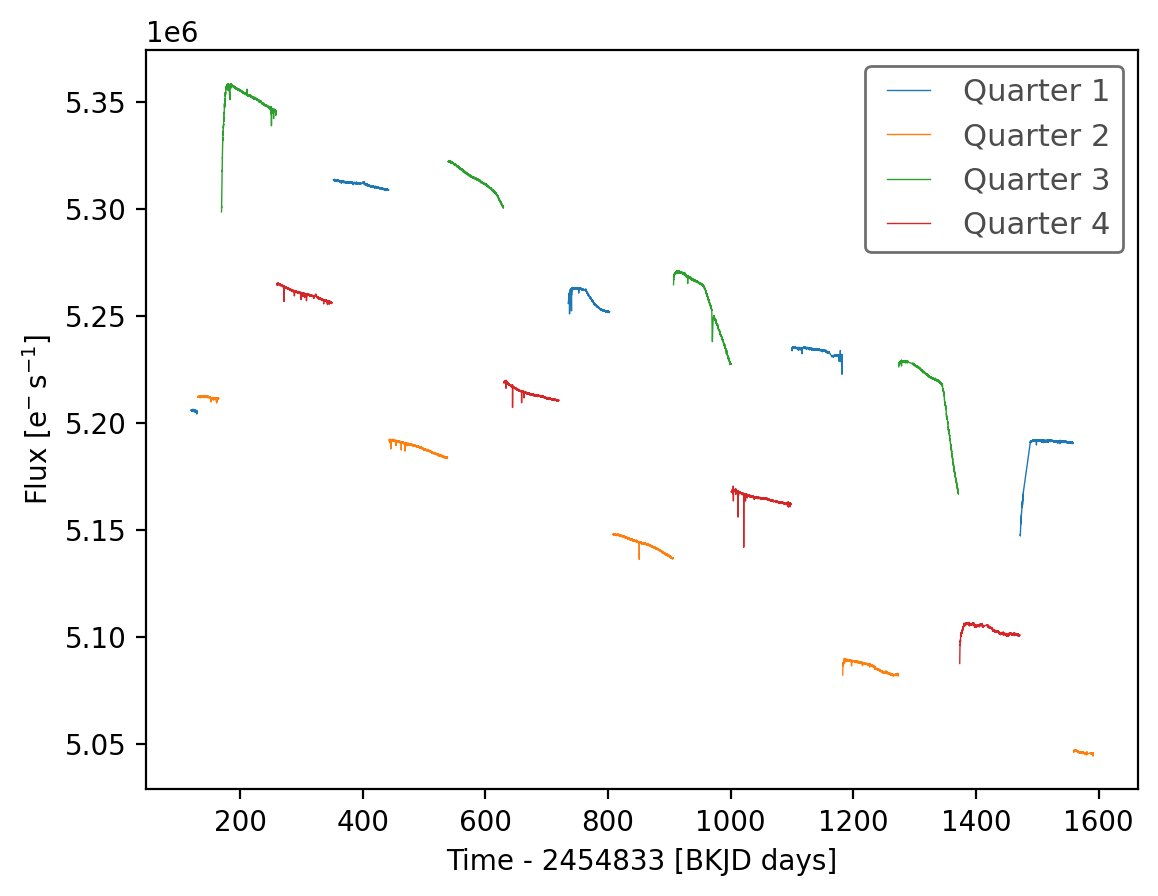

In [6]:
fig, ax = plt.subplots()
for i in range(len(lcs)):
    lcs[i].plot(ax=ax, label=f"Quarter {lcs[i].QUARTER % 4 + 1}" if i < 4 else None, color=plt.get_cmap("tab10")(lcs[i].QUARTER % 4))

Now we can use LightKurve to stitch together the lightcurves from different quarters, flatten them and remove any outliers.

<AxesSubplot: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

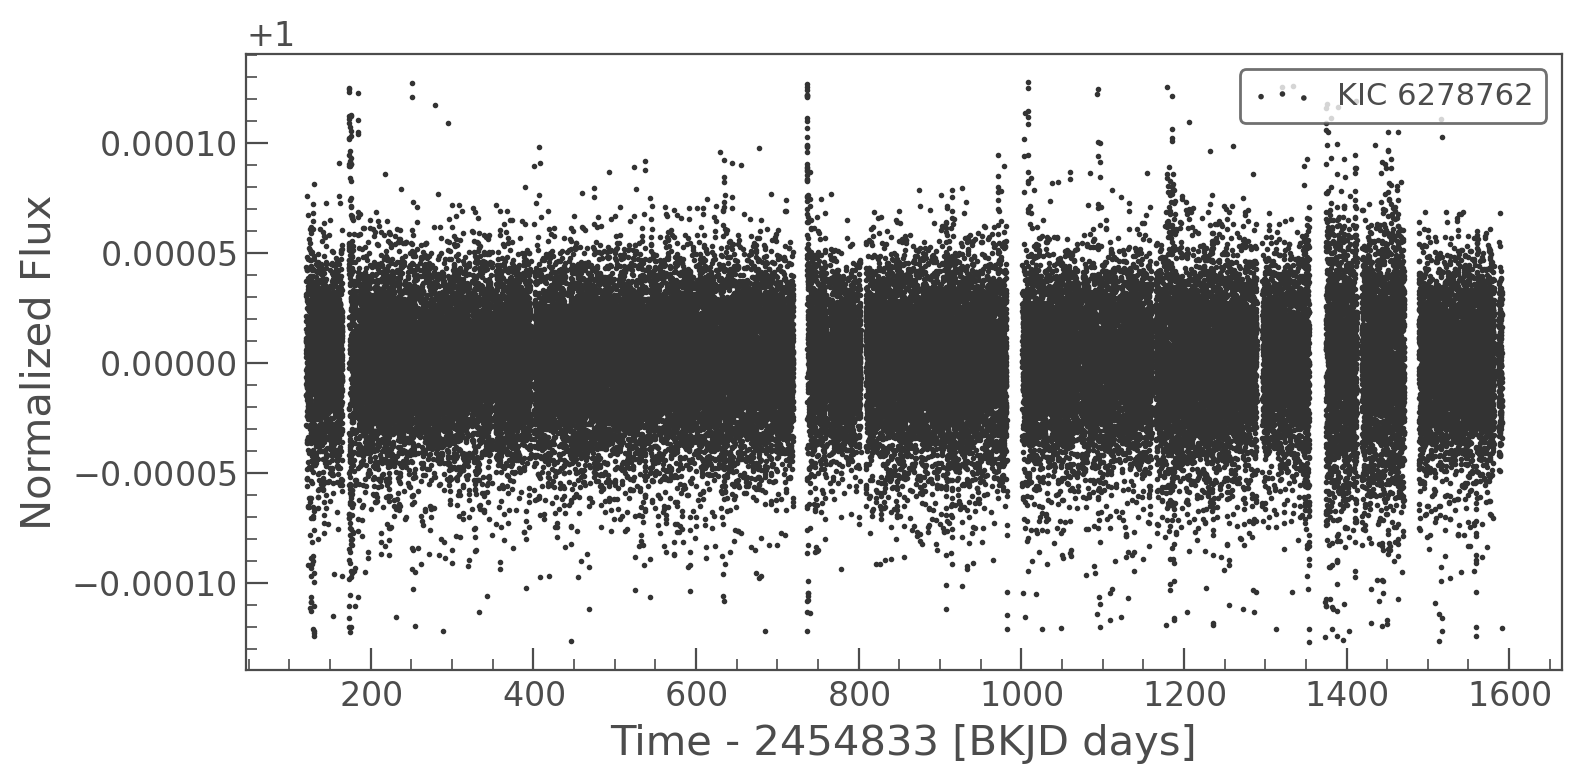

In [7]:
lc = lcc.stitch().flatten().remove_outliers()
lc.scatter()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods

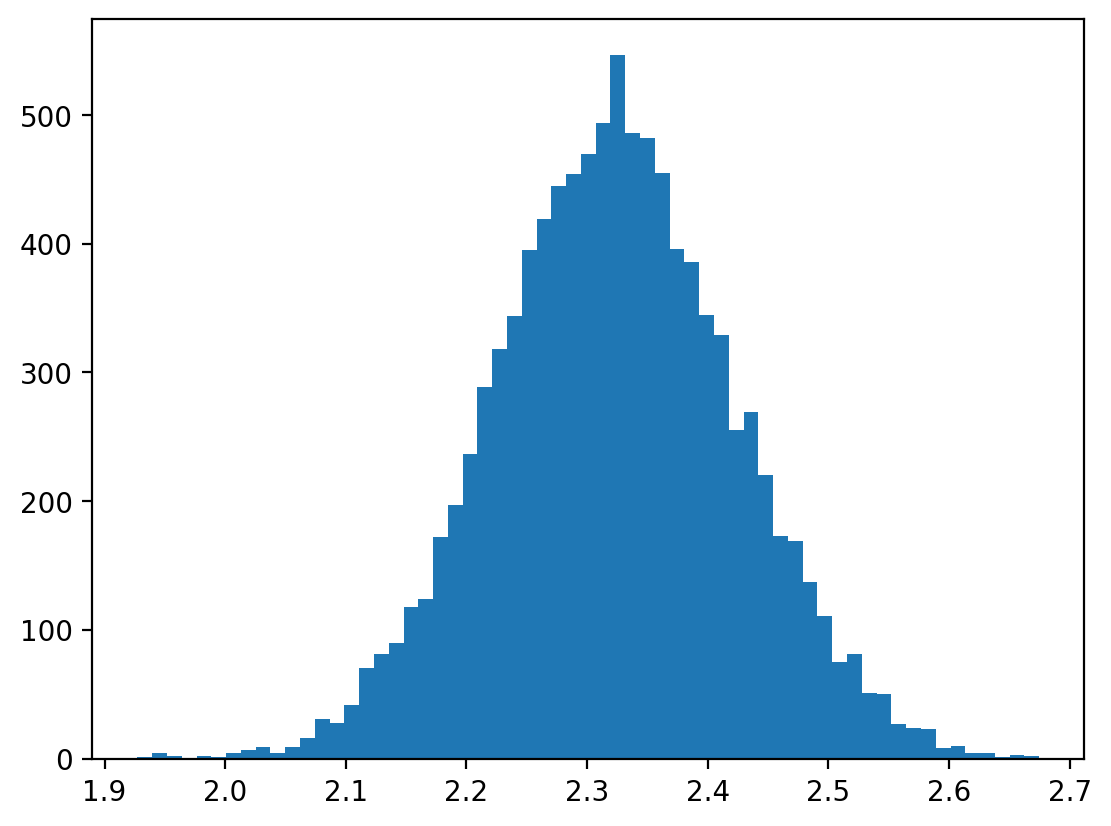

In [33]:
plt.hist(np.random.normal(loc=2.3237462, scale=0.1, size=10000), bins="fd");

In [35]:
kepler_start = 2454833 * u.day
planets = ['b', 'c', 'd', 'e', 'f']
planet_parameters = {
    "b": {
        "period": 3.6001053 * u.day,
        "t0": Time(2454966.2599 * u.day, format="jd")
    },
    "c" : {
        "period": 4.5458841 * u.day,
        "t0": Time(2454964.5220 * u.day, format="jd")
    },
    'd' : {
        "period": 6.189392 * u.day,
        "t0": Time(2454967.7869 * u.day, format="jd")
    },
    'e' : {
        "period": 7.743493 * u.day,
        "t0": Time(2454968.0927 * u.day, format="jd")
    },
    'f' : {
        "period": 9.740486 * u.day,
        "t0": Time(2454967.8791 * u.day, format="jd")
    },
}

star_parameters = {
    "rho": 2.3237462 * u.g / u.cm**3
}

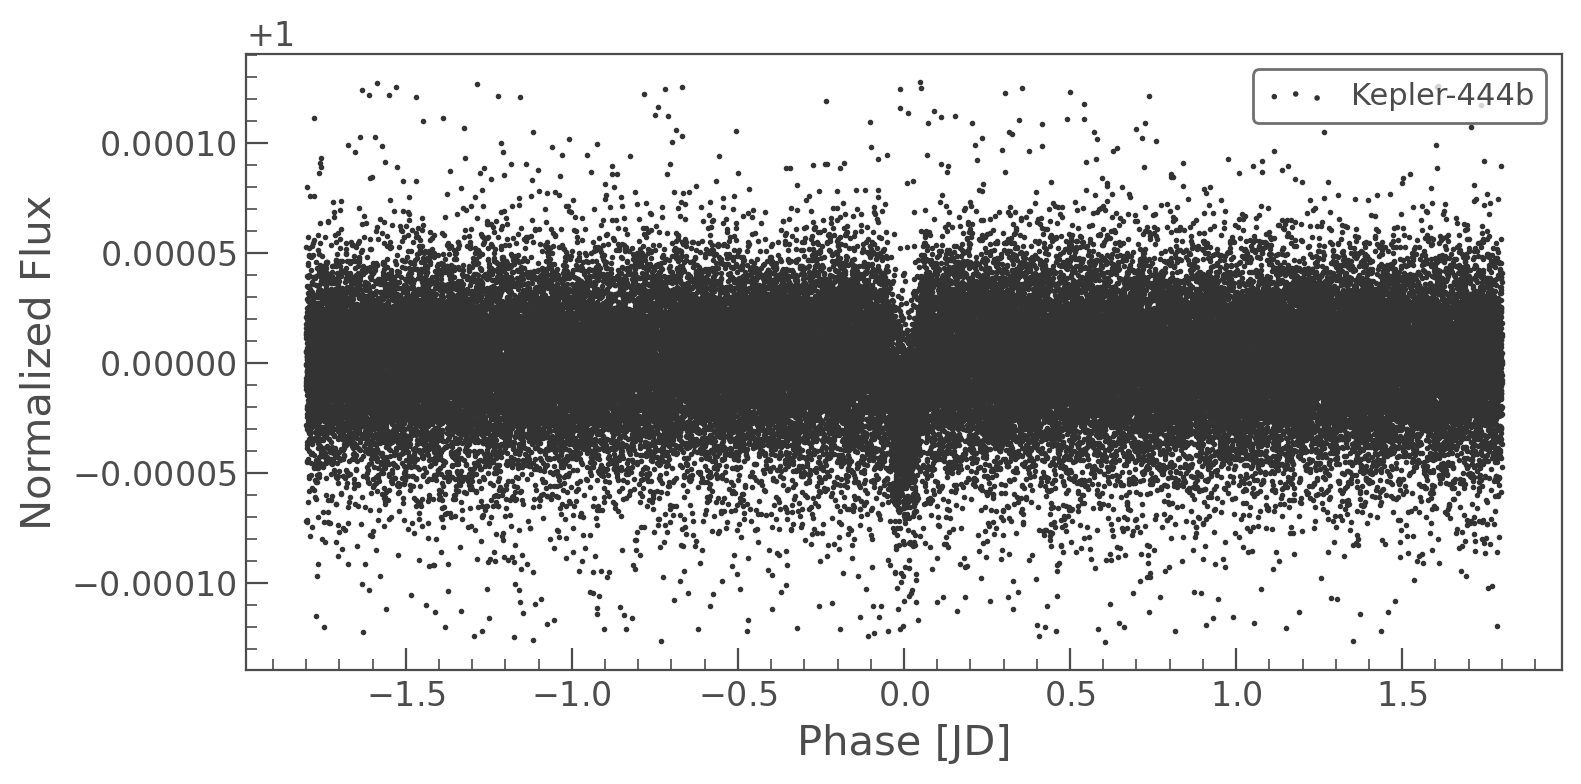

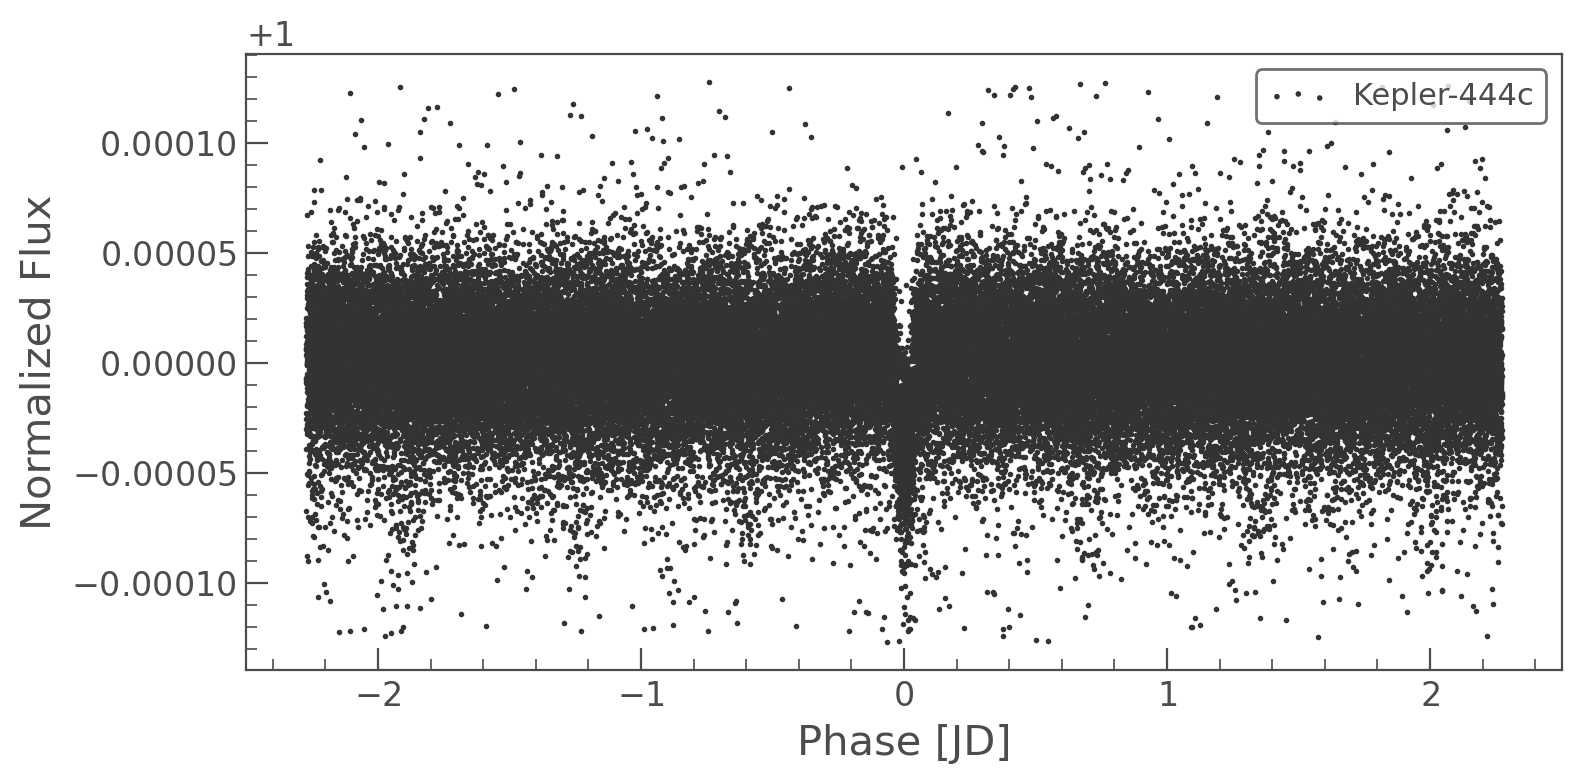

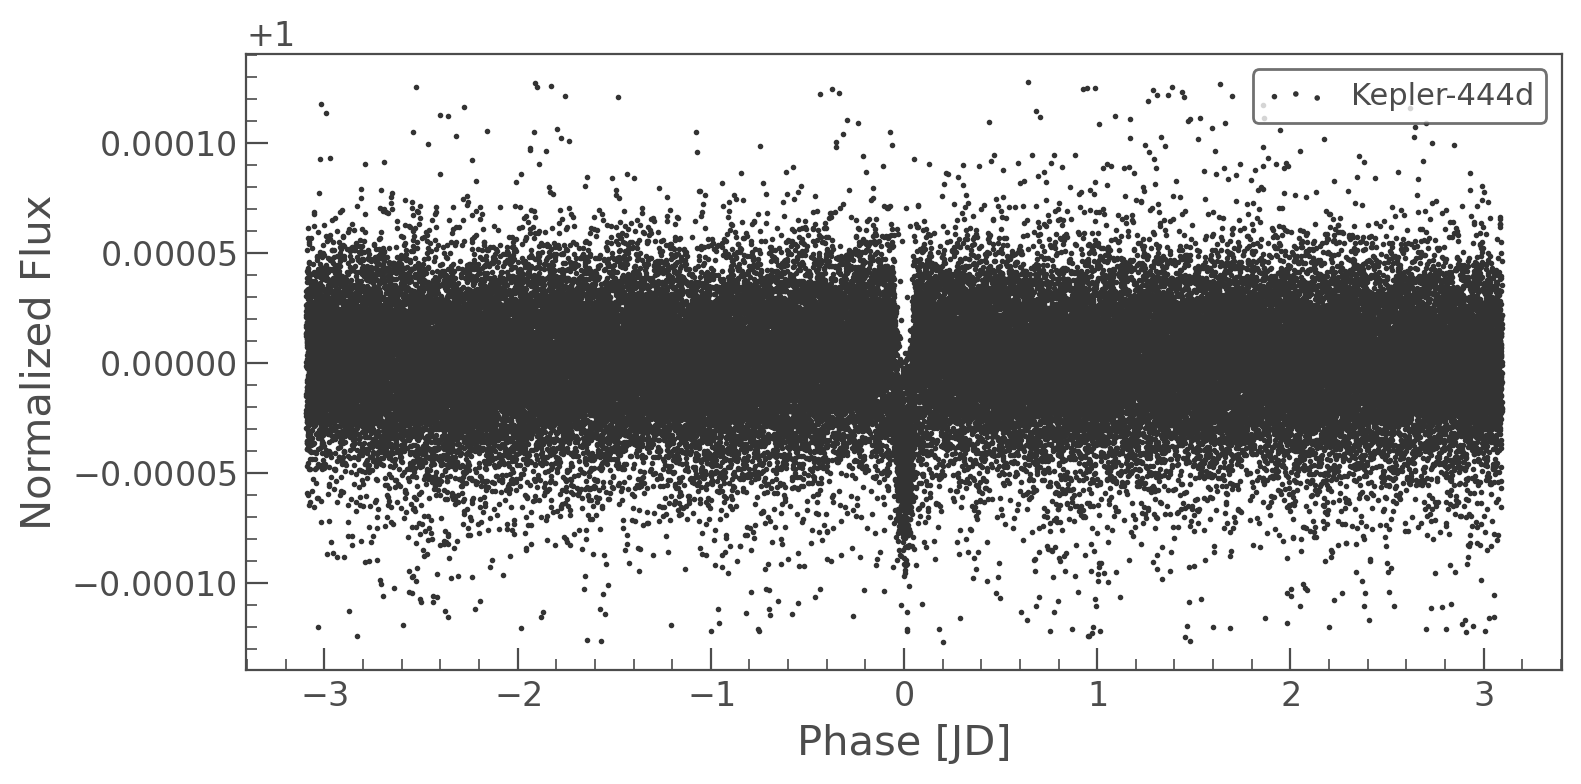

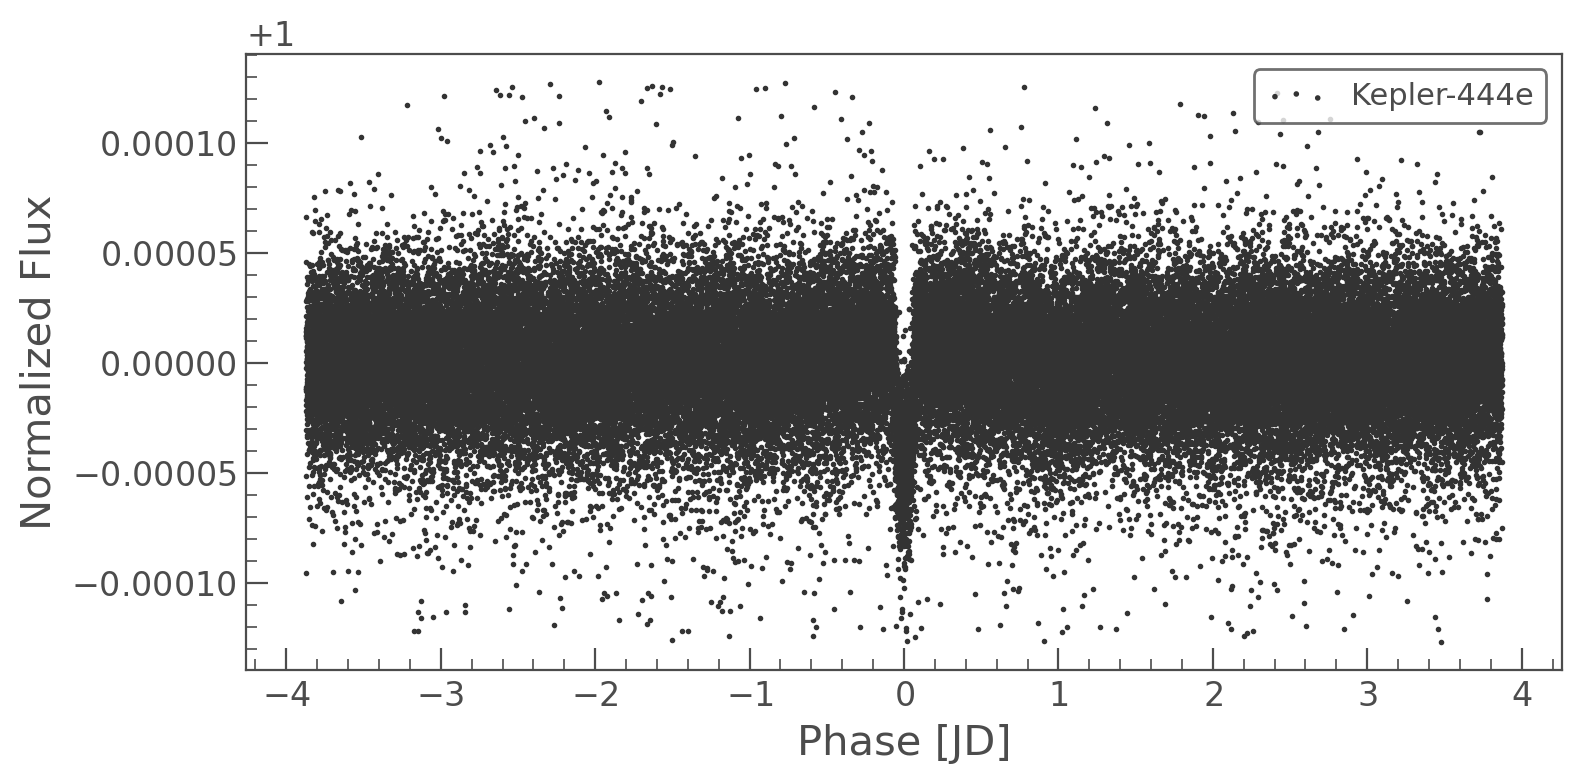

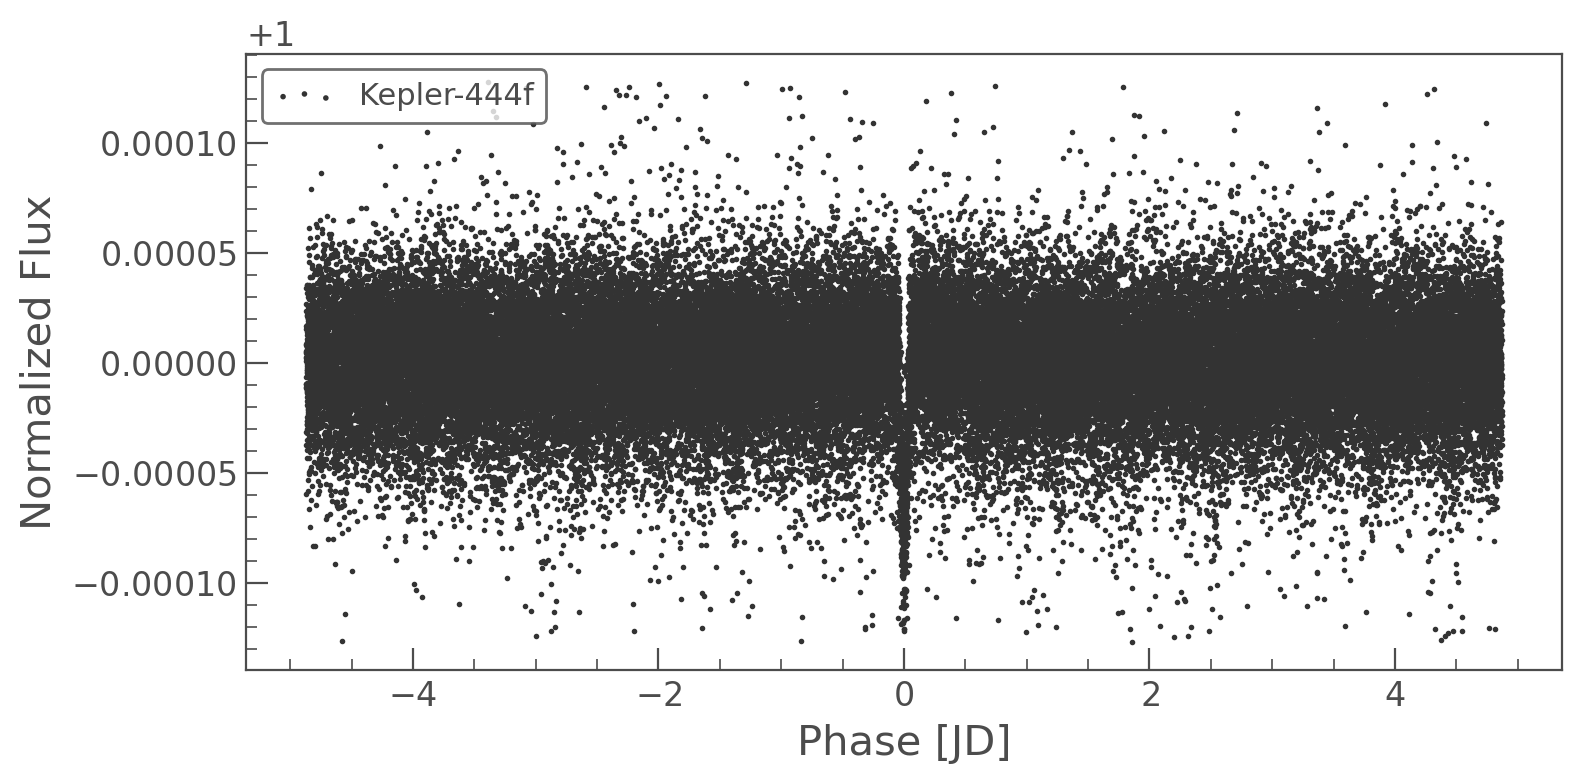

In [9]:
for planet in planets:
    ax = lc.fold(period=planet_parameters[planet]["period"], epoch_time=planet_parameters[planet]["t0"].bkjd).scatter(label=f"Kepler-444{planet}")    
    # ax.axvline((planet_parameters[planet]["t0"] - kepler_start).value % planet_parameters[planet]["period"].value)

# Now to fit things

In [36]:
import pymc3 as pm
import pymc3_ext as pmx

periods = [planet_parameters[p]["period"].value for p in planet_parameters]
t0s = [planet_parameters[p]["t0"].bkjd for p in planet_parameters]
yerr = 5e-4

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=len(t0s))

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=len(periods))
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    limb_dark = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.001, upper=0.1, shape=len(periods), testval=np.ones_like(periods) * 0.01
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=len(periods), testval=np.random.rand(len(periods))
    )

    rho_star = pm.Normal("rho_star", mu=star_parameters["rho"].to(u.g / u.cm**3).value, sd=0.1)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, rho_star=rho_star)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(limb_dark[0], limb_dark[1]).get_light_curve(
        orbit=orbit, r=r, t=lc["time"].value
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    # y = pmx.eval_in_model(light_curve)
    # y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    y = lc["flux"].value

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=lc["flux_err"].value, observed=y)

    # Fit for the maximum a posteriori parameters given the simulated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 428809.1222589077 -> 515744.94565557345


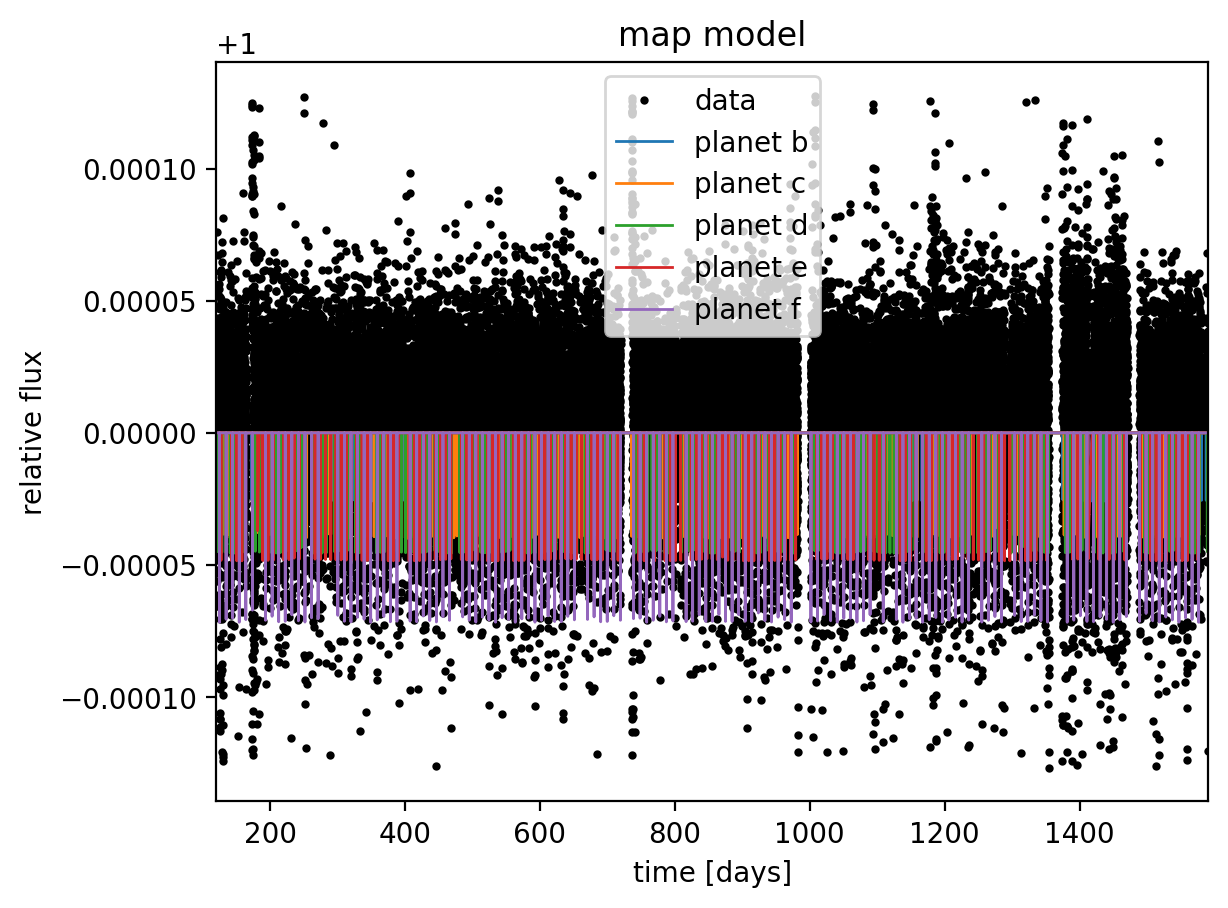

In [37]:
t = lc["time"].value
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bcdef"):
    plt.plot(
        t, map_soln["light_curves"][:, i] + 1, lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [42]:
with model:
    trace = pmx.sample(
        tune=10,
        draws=10,
        start=map_soln,
        cores=6,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Only 10 samples in chain.
Multiprocess sampling (2 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 6 jobs)
NUTS: [rho_star, b, r, u, logP, t0, mean]
INFO:pymc3:NUTS: [rho_star, b, r, u, logP, t0, mean]


Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 10 seconds.
INFO:pymc3:Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 10 seconds.


In [ ]:
import corner

truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)

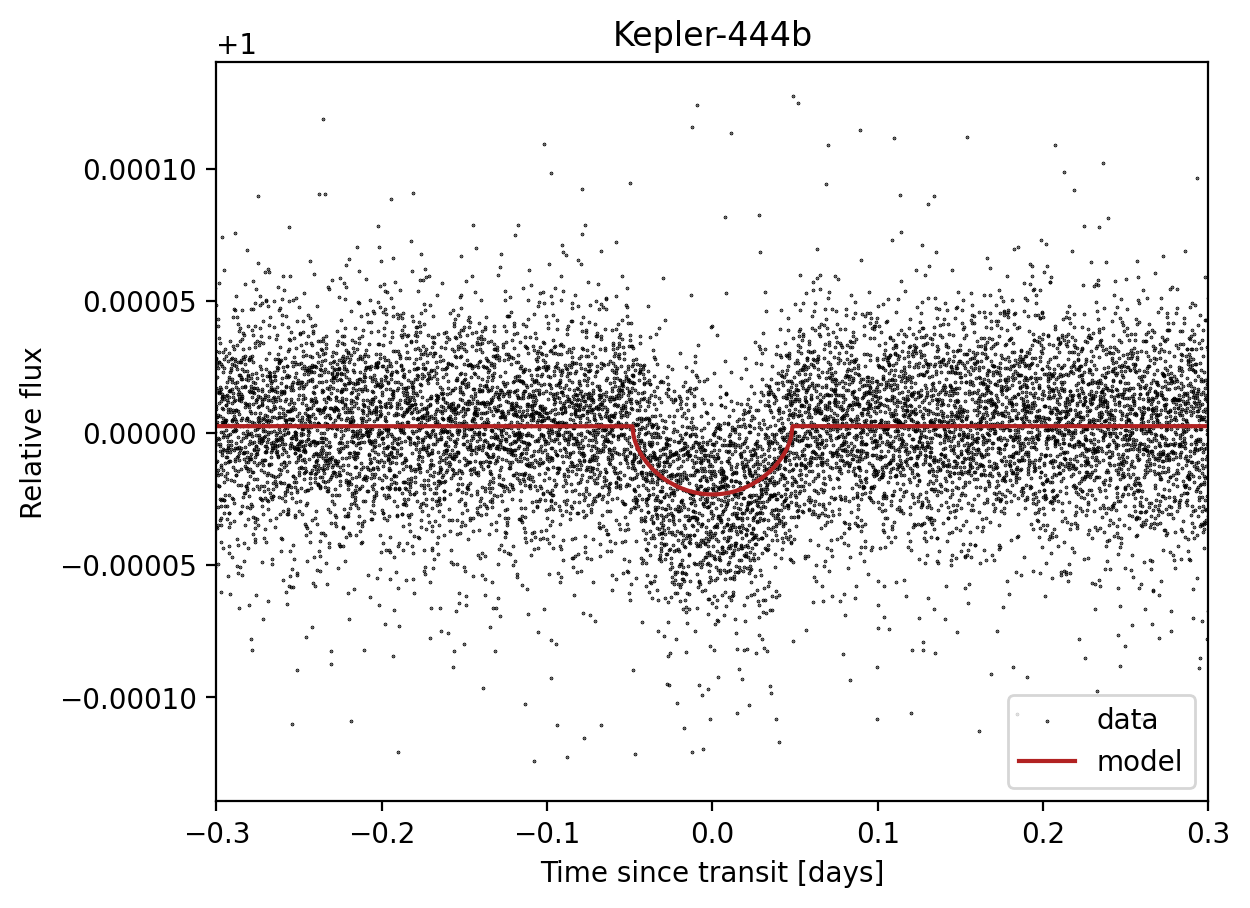

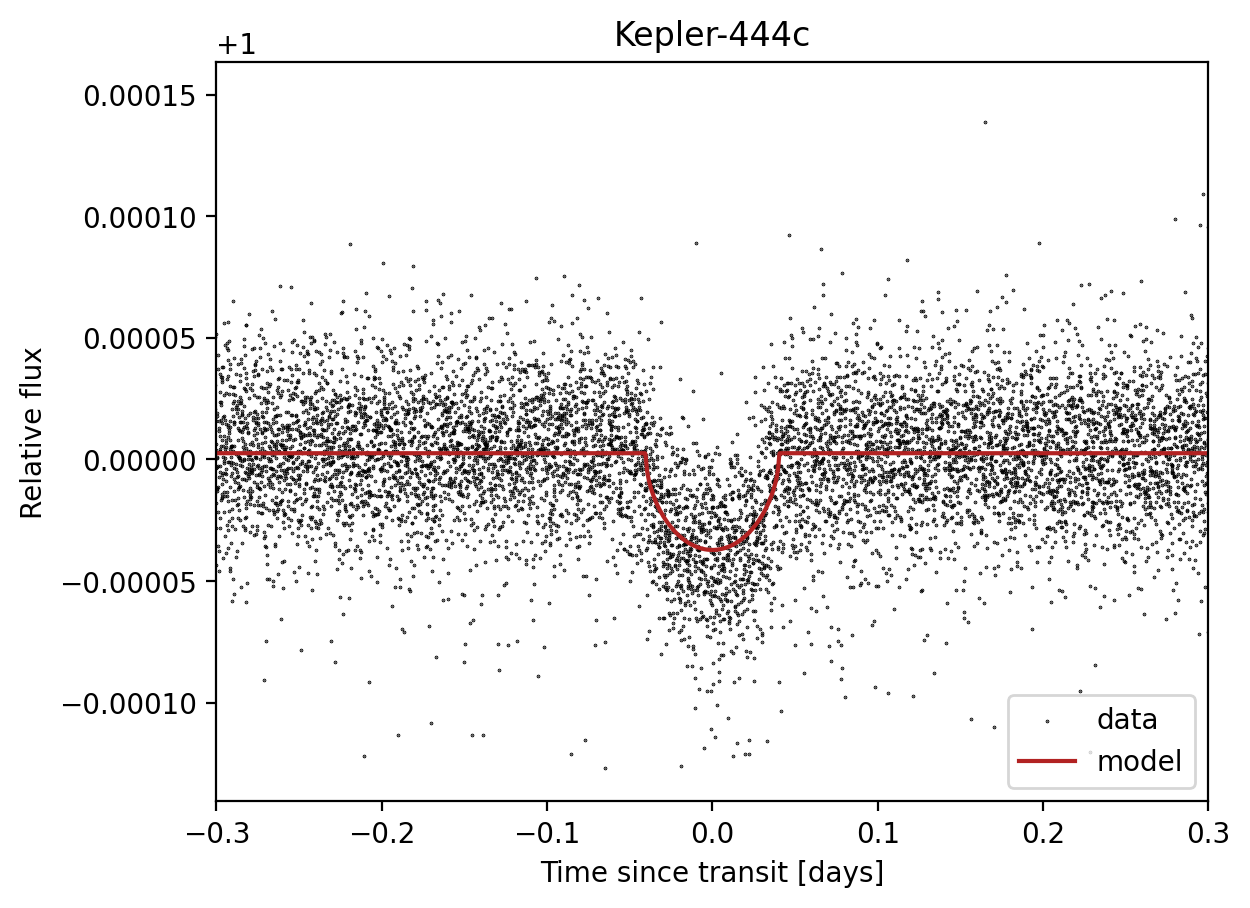

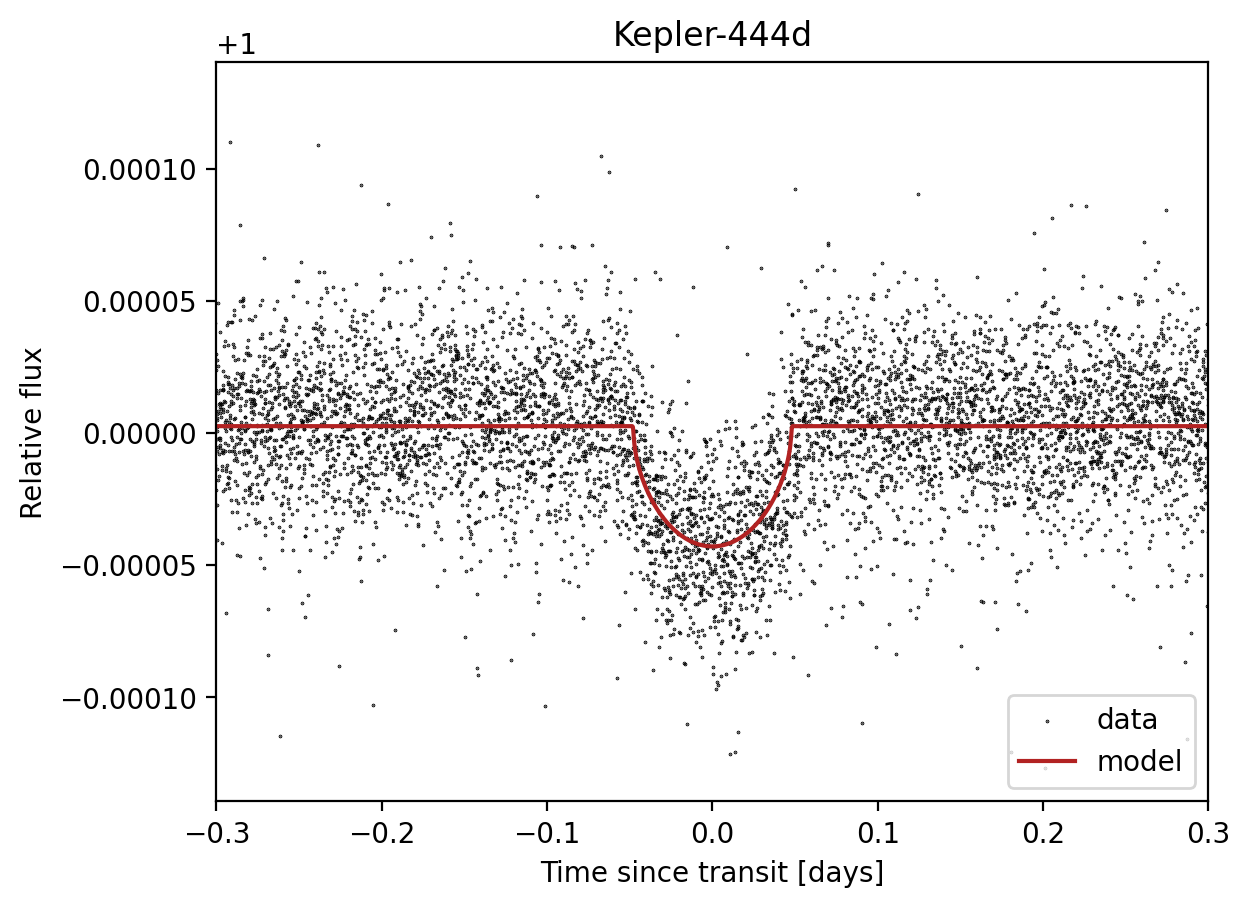

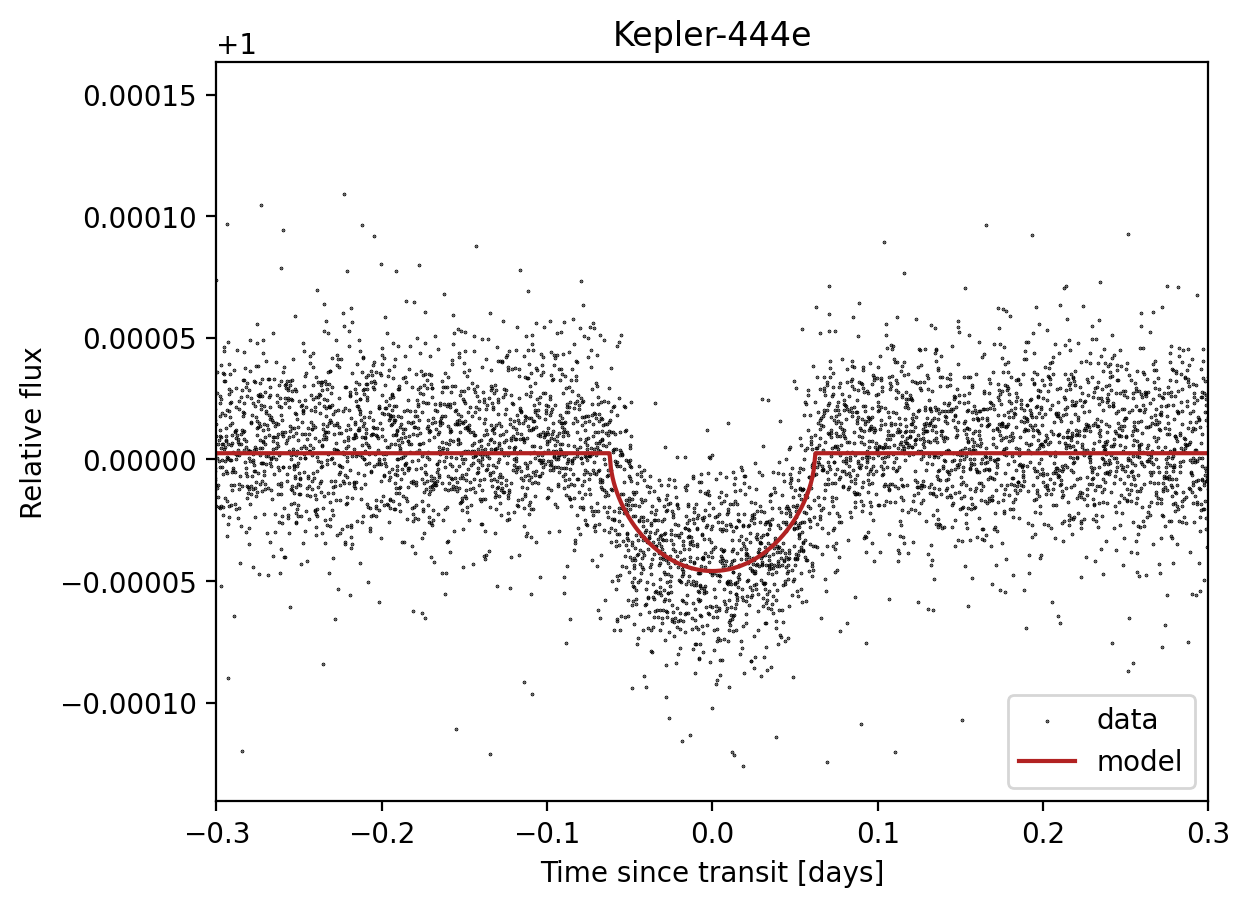

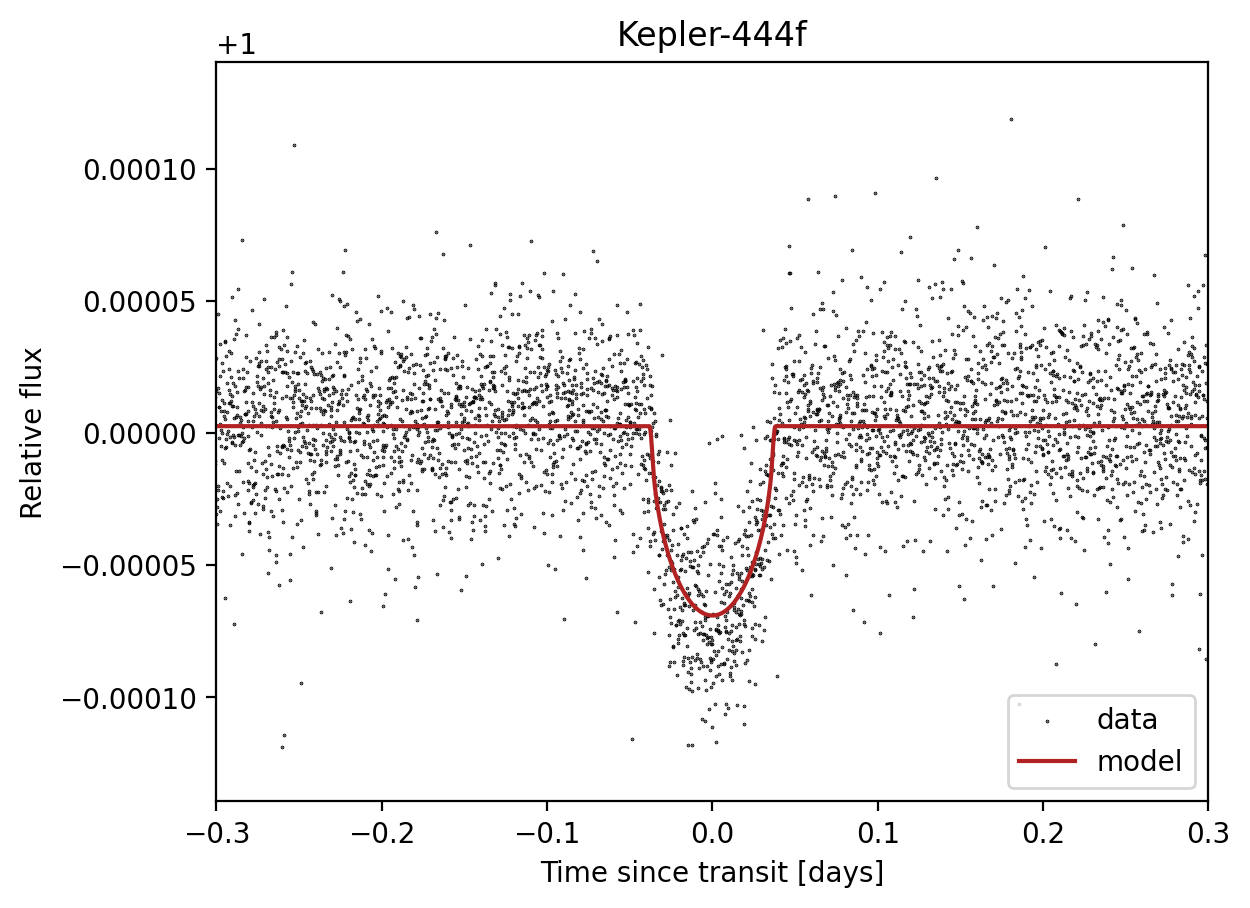

In [46]:
for n, letter in enumerate("bcdef"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y - other, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="firebrick", label="model")

    # Annotate the plot with the planet's period
    # txt = "period = {0:.4f} +/- {1:.4f} d".format(
    #     np.mean(period_trace), np.std(period_trace)
    # )
    # plt.annotate(
    #     txt,
    #     (0, 0),
    #     xycoords="axes fraction",
    #     xytext=(5, 5),
    #     textcoords="offset points",
    #     ha="left",
    #     va="bottom",
    #     fontsize=12,
    # )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(f"Kepler-444{letter}")
    plt.xlim(-0.3, 0.3)

In [39]:
map_soln

{'mean': array(1.00000258),
 't0': array([133.25919176, 131.52259478, 134.7847395 , 135.09228572,
        134.87789568]),
 'logP': array([1.28096538, 1.51422311, 1.8228415 , 2.04685394, 2.27629257]),
 'u_quadlimbdark__': array([3.77288206, 0.34015884]),
 'r_interval__': array([-3.42200465, -2.94815063, -2.91217705, -3.0066318 , -2.3526216 ]),
 'b_impact__': array([-1.31438971,  0.62989758,  0.34041877, -1.22995348,  1.6286476 ]),
 'rho_star': array(2.29049921),
 'period': array([3.60011354, 4.54588809, 6.18942071, 7.74350125, 9.74050116]),
 'u': array([ 1.15525644, -0.1665549 ]),
 'r': array([0.00412986, 0.00593258, 0.00610393, 0.00566559, 0.0095989 ]),
 'b': array([0.21262773, 0.65633704, 0.58785872, 0.22747106, 0.84400882]),
 'light_curves': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}

In [ ]:
map_soln

{'mean': array(1.00000258),
 't0': array([133.25918623, 131.52260428, 134.78412339, 135.09271904,
        134.87803626]),
 'logP': array([1.28096533, 1.51422297, 1.82284166, 2.04685352, 2.27629237]),
 'u_quadlimbdark__': array([4.3361938 , 0.46426408]),
 'r_interval__': array([-3.29888587, -2.82983123, -2.80942752, -2.8932775 , -2.23569926]),
 'b_impact__': array([0.21978297, 1.16001295, 0.90080022, 0.22088466, 1.98476134]),
 'period': array([3.60011335, 4.54588746, 6.18942172, 7.74349801, 9.74049922]),
 'u': array([ 1.22009322, -0.22657282]),
 'r': array([0.00452533, 0.00651759, 0.00662487, 0.0061962 , 0.01056243]),
 'b': array([0.55723595, 0.76629714, 0.71582496, 0.55843661, 0.88847417]),
 'light_curves': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}